In [1]:
import sys
sys.path.append("/home/akdiaz/Documents/Trabajo/Scripts/Python_modules")
sys.path.append("/home/akdiaz/Documents/CASA_releases/analysis_scripts")
import analysisUtils as au
from astropy import units as u
import numpy as np
import parameters as par
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt 
from matplotlib import rc
from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

K = constants.k * u.kg * u.m**2 * u.s**(-2) * u.K**(-1) #Boltzmann constant
G = constants.G * u.m**3 * u.kg**(-1) * u.s**(-2) #Gravitational constant
H = constants.h*u.J*u.s #Planck's constant
C = constants.c*100*u.cm*u.s**-1 #Speed of light in cm/s

You appear to be importing analysisUtils into python (not CASA). version =  3.8.5
CASAPATH is not defined, so I am skipping a lot of imports


# Proper motions (DR2)

In [3]:
data_in='/home/akdiaz/Documents/Trabajo/SVS13/Images/VLA/proper_motions/'

In [6]:
file_A = data_in + 'pm-A-all-final.dat'
file_B = data_in + 'pm-B-all-final.dat'
dataA = np.loadtxt(file_A, skiprows=1, usecols = [0,1,2,3,4])
dataB = np.loadtxt(file_B, skiprows=1, usecols = [0,1,2,3,4])
timeA= [i[0] for i in dataA]
RA_A=[i[1] for i in dataA]
E_RA_A=[i[2] for i in dataA]
DEC_A=[i[3] for i in dataA]
E_DEC_A=[i[4] for i in dataA]
timeB= [i[0] for i in dataB]
RA_B=[i[1] for i in dataB]
E_RA_B=[i[2] for i in dataB]
DEC_B=[i[3] for i in dataB]
E_DEC_B=[i[4] for i in dataB]
if timeA==timeB:
    time=timeA
    teo_RA_A=[0.0005987800990965202*t+2.538137709793499 for t in timeA]
    teo_DEC_A=[-0.009186172096178849*t+22.29720008517562 for t in timeA]
    teo_RA_B=[0.0006241789738361716*t+2.5099225057460672 for t in timeA]
    teo_DEC_B=[-0.010789256173226411*t+25.52782804627961 for t in timeA]
    difAR_A=(np.array(RA_A)-np.array(teo_RA_A))
    difAR_B=(np.array(RA_B)-np.array(teo_RA_A))
    difDEC_A=np.array(DEC_A)-np.array(teo_DEC_A)
    difDEC_B=np.array(DEC_B)-np.array(teo_DEC_A)
    dif_teo_AR_A=np.array(teo_RA_A)-np.array(teo_RA_A)
    dif_teo_DEC_A=np.array(teo_DEC_A)-np.array(teo_DEC_A)
    dif_teo_AR_B=np.array(teo_RA_B)-np.array(teo_RA_A)
    dif_teo_DEC_B=np.array(teo_DEC_B)-np.array(teo_DEC_A)
else:
    print('check epochs')

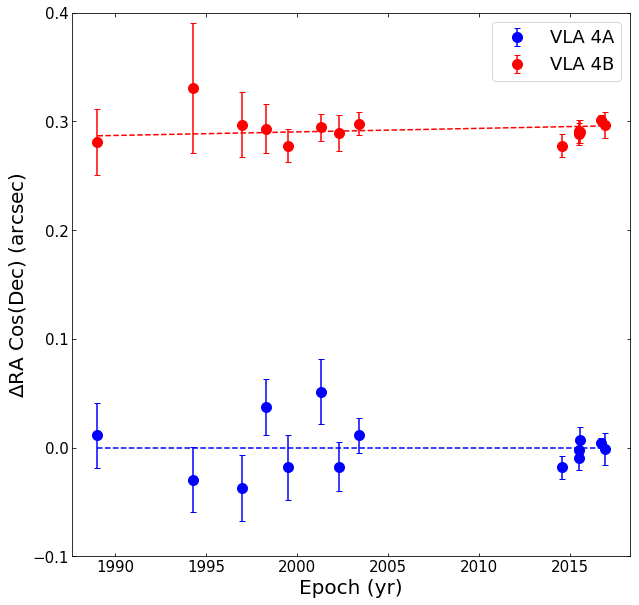

In [105]:
a=15*np.cos(31*np.pi/180)
plt.figure(figsize=(10,10))
plt.tick_params(right=True, top=True,direction='in')
plt.xlabel('Epoch (yr)',fontsize=20)
plt.ylabel('$\Delta$RA Cos(Dec) (arcsec)',fontsize=20)
plt.errorbar(time,difAR_A*a, xerr=None,yerr=np.array(E_RA_A)*15, fmt='ob', capsize=3, ms=10,label='VLA 4A')
plt.errorbar(time,difAR_B*a, xerr=None,yerr=np.array(E_RA_B)*15, fmt='or', capsize=3, ms=10,label='VLA 4B')
plt.plot(time,dif_teo_AR_A*a,'--b')
plt.plot(time,dif_teo_AR_B*a,'--r')
plt.legend(fontsize=18)
plt.ylim(-0.1,0.4)
plt.savefig('AR-dif.png',bbox='tight')

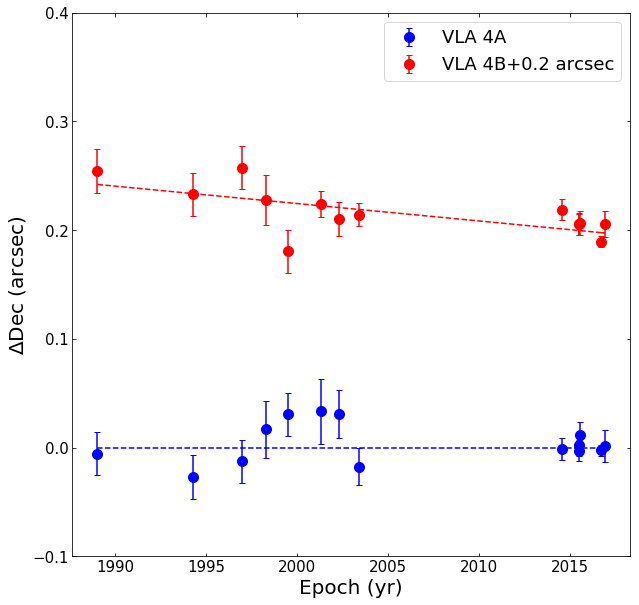

In [119]:
a=0.2
ax=plt.figure(figsize=(10,10))
#ax.text(0.15, 0.7, '+0.2 arcsec', fontsize=15)
plt.tick_params(right=True, top=True,direction='in')
plt.xlabel('Epoch (yr)',fontsize=20)
plt.ylabel('$\Delta$Dec (arcsec)',fontsize=20)
plt.errorbar(time,difDEC_A, xerr=None,yerr=E_DEC_A, fmt='ob', capsize=3, ms=10,label='VLA 4A')
plt.errorbar(time,difDEC_B+a, xerr=None,yerr=E_DEC_B, fmt='or', capsize=3, ms=10,label='VLA 4B+0.2 arcsec')
plt.plot(time,dif_teo_DEC_A,'--b')
plt.plot(time,dif_teo_DEC_B+a,'--r')
plt.ylim(-0.1,0.4)
plt.legend(fontsize=18)
plt.savefig('DEC-dif.png',bbox='tight')

In [36]:
def proper_motions(file, file_out, label, color, dec, extra_points=False, extra_plot=False):
    '''Does a fit to the proper motion and generates two plots. File and label are lists (one component per source).
    If extra_plot is set (must be [a1,b1,a2,b2]) a line y = a1 x + b1 is plot on top of AR plot and  a line
    y = a2 x + b2 on top of DEC plot.'''
    data = [np.loadtxt(f, skiprows=1, usecols = [0,1,2,3,4]) for f in file]
    time=[]
    RA=[]
    E_RA=[]
    DEC=[]
    E_DEC=[]
    RA_fit=[]
    DEC_fit=[]
    label_AR=[]
    label_DEC=[]
    label_AR_final=[]
    label_DEC_final=[]
    for d in data:
        time.append([i[0] for i in d])
        RA.append([i[1] for i in d])
        E_RA.append([i[2] for i in d])
        DEC.append([i[3] for i in d])
        E_DEC.append([i[4] for i in d])
        time_fit = np.linspace(min(time[-1]),max(time[-1]),10)
        # lets fit linear for AR (a*t+b)
        parRA, varRA = np.polyfit(time[-1], RA[-1], 1, w=1/np.array(E_RA[-1]), cov=True)
        aRA = parRA[0]
        bRA = parRA[1]
        RA_fit.append(aRA*time_fit+bRA)
        E_aRA = np.sqrt(varRA[0,0])
        E_bRA = np.sqrt(varRA[1,1])
        print(f'eq for RA: {aRA}*t+{bRA}')
        # lets fit linear for DEC (a*t+b)
        parDEC, varDEC = np.polyfit(time[-1], DEC[-1], 1, w=1/np.array(E_DEC[-1]), cov=True)
        aDEC = parDEC[0]
        bDEC = parDEC[1]
        DEC_fit.append(aDEC*time_fit+bDEC)
        E_aDEC = np.sqrt(varDEC[0,0])
        E_bDEC = np.sqrt(varDEC[1,1])
        print(f'eq for DEC: {aDEC}*t+{bDEC}')
        # labels
        label_AR.append(f': $\mu_\\alpha$ cos $\\delta$ = {round(aRA*15*1000*np.cos(dec),1)}$\pm${round(E_aRA*15*1000*np.cos(dec),1)} mas/yr')
        label_DEC.append(f': $\mu_\\delta$ = {round(aDEC*1000,1)}$\pm${round(E_aDEC*1000,1)} mas/yr')
    if extra_points != False:
        extra_data = np.loadtxt(extra_points, skiprows=1, usecols = [0,1,2,3,4])
        extra_time = [i[0] for i in extra_data]
        extra_RA = [i[1] for i in extra_data]
        extra_E_RA = [i[2] for i in extra_data]
        extra_DEC = [i[3] for i in extra_data]
        extra_E_DEC = [i[4] for i in extra_data]
    if extra_plot != False:
        extra_RA_fit = extra_plot[0]*time_fit+extra_plot[1]
        extra_DEC_fit = extra_plot[2]*time_fit+extra_plot[3]
    # do the AR plot
    plt.figure(figsize=(10,10))
    plt.tick_params(right=True, top=True,direction='in')
    rc('xtick', labelsize=15) 
    rc('ytick', labelsize=15)
    plt.legend(fontsize=18)
    plt.xlabel('Epoch (yr)',fontsize=20)
    plt.ylabel('J2000 RA (s)',fontsize=20)
    pp = []
    for i,_ in enumerate(data):
        p = plt.errorbar(time[i], RA[i], xerr=None,yerr=E_RA[i], fmt='o'+color[i], capsize=3, ms=10)
        pp.append(p[0])
        plt.plot(time_fit, RA_fit[i],'--'+color[i])
        label_AR_final.append(label[i]+label_AR[i])
    if extra_points != False:
        plt.errorbar(extra_time, extra_RA, xerr=None,yerr=extra_E_RA, fmt='o'+color[-1], capsize=3, ms=10)
    if extra_plot != False:
        plt.plot(time_fit, extra_RA_fit,'--'+color[-1])
    plt.legend(pp, label_AR_final,fontsize=18,loc=2)
    plt.savefig(f'AR{file_out}.png',bbox='tight')
    # do the DEC plot
    plt.figure(figsize=(10,10))
    plt.tick_params(right=True, top=True,direction='in')
    #rc('xtick', labelsize=15) 
    #rc('ytick', labelsize=15)
    plt.xlabel('Epoch (yr)',fontsize=20)
    plt.ylabel('J2000 Dec (Arcsec)',fontsize=20)
    pp = []
    for i,_ in enumerate(data):
        p = plt.errorbar(time[i], DEC[i], xerr=None,yerr=E_DEC[i], fmt='o'+color[i],capsize=3,ms=10)
        pp.append(p[0])
        plt.plot(time_fit, DEC_fit[i],'--'+color[i])
        label_DEC_final.append(label[i]+label_DEC[i])
    if extra_points != False:
        plt.errorbar(extra_time, extra_DEC, xerr=None,yerr=extra_E_DEC, fmt='o'+color[-1], capsize=3, ms=10)
    if extra_plot != False:
        plt.plot(time_fit, extra_DEC_fit,'--'+color[-1])
    plt.legend(pp, label_DEC_final, fontsize=18)
    plt.savefig(f'DEC{file_out}.png',bbox='tight')

In [13]:
def plot_movements(file1,file2):
    '''Plots the distance and PA between sources as a function of time.'''
    data1 = np.loadtxt(file1, skiprows=1, usecols = [0,1,2,3,4,5,6,7,8])
    data2 = np.loadtxt(file2, skiprows=1, usecols = [0,1,2,3,4,5,6,7,8])
    time1 = [i[0] for i in data1]
    time2 = [i[0] for i in data2] 
    if time1 == time2:
        ar1 = [ufloat((i[1]*3600+i[2]*60+i[3])*15,i[4]*15) for i in data1] #in arcsec
        ar2 = [ufloat((i[1]*3600+i[2]*60+i[3])*15,i[4]*15) for i in data2]#in arcsec
        dec1 = [ufloat(i[5]*3600+i[6]*60+i[7], i[8]) for i in data1] #in arcsec
        dec2 = [ufloat(i[5]*3600+i[6]*60+i[7], i[8]) for i in data2] #in arcsec
        sep = [sqrt(((a2-a1)*cos(d1/3600*np.pi/180))**2+(d2-d1)**2) for a1,a2,d1,d2 in zip(ar1,ar2,dec1,dec2)] #in arcsec
        pa = [90-asin((d2-d1)/s)*180/np.pi for d1,d2,s in zip(dec1,dec2,sep)] #in degrees
        sep_value = [i.n for i in sep]
        sep_error = [i.s for i in sep]
        pa_value = [i.n for i in pa]
        pa_error = [i.s for i in pa]
        min_sep = min(sep_value)-2*max(sep_error)
        max_sep = max(sep_value)+2*max(sep_error)
        min_pa = min(pa_value)-2*max(pa_error)
        max_pa = max(pa_value)+2*max(pa_error)
        #coor1 = [f'{int(i[1])}:{int(i[2])}:{i[3]} {int(i[5])}:{int(i[6])}:{i[7]}' for i in data1]
        #coor2 = [f'{int(i[1])}:{int(i[2])}:{i[3]} {int(i[5])}:{int(i[6])}:{i[7]}' for i in data2]
        #source_1 = [SkyCoord(c, frame='fk5', unit=(u.hourangle, u.deg)) for c in coor1]
        #source_2 = [SkyCoord(c, frame='fk5', unit=(u.hourangle, u.deg)) for c in coor2]
        #sep = [s1.separation(s2).arcsec for s1,s2 in zip(source_1,source_2)]
        #pa = [s1.position_angle(s2).deg for s1,s2 in zip(source_1,source_2)]
        # do the sep plot
        plt.figure(figsize=(10,10))
        plt.tick_params(right=True, top=True,direction='in')
        rc('xtick', labelsize=15) 
        rc('ytick', labelsize=15)
        plt.xlabel('Epoch (yr)',fontsize=20)
        plt.ylabel('Separation (Arcsec)',fontsize=20)
        plt.ylim(min_sep, max_sep)
        plt.errorbar(time1, sep_value, xerr=None,yerr=sep_error, fmt='-ob', capsize=3, ms=10)
        #plt.plot(time1, sep,'o-b')
        #plt.savefig('sep.png',bbox='tight')
        # do the pa plot
        plt.figure(figsize=(10,10))
        plt.tick_params(right=True, top=True,direction='in')
        rc('xtick', labelsize=15) 
        rc('ytick', labelsize=15)
        plt.xlabel('Epoch (yr)',fontsize=20)
        plt.ylabel('Position Angle (Degree)',fontsize=20)
        plt.ylim(min_pa, max_pa)
        plt.errorbar(time1, pa_value, xerr=None,yerr=pa_error, fmt='-or', capsize=3, ms=10)
        #plt.plot(time1, pa,'o-r')
        #plt.savefig('pa.png',bbox='tight')
        print(sep)
        print(pa)
    else:
        print('The epochs of the coordinates most be equal for both sources. Check them.')
        print(time1)
        print(time2)

[0.2758508314296745+/-0.03403017722690808, 0.3639748735389158+/-0.056139954390629264, 0.34062318359129157+/-0.0340755777968727, 0.25538017692041054+/-0.026442885683786197, 0.2990979290761723+/-0.02804184462621362, 0.23736408786091315+/-0.02519876041376327, 0.30714698171854693+/-0.019590027548743526, 0.28769944194217884+/-0.011844293650950978, 0.2955666730535078+/-0.0013818762396468809, 0.2924344315740842+/-0.0028668387251684986, 0.29746861703291905+/-0.002866897501671497, 0.2833941948911687+/-0.007476210833051629, 0.29748039500595985+/-0.010337094675369718, 0.2962794016858921+/-0.0005734617553630383]
[77.4372416119113+/-5.1164993601975395, 80.51167998486187+/-4.013024876591297, 78.14089715380987+/-4.132985608565368, 87.53133297756224+/-7.152695964416268, 99.62327843347533+/-4.629263006880528, 92.1729725721523+/-7.434251729977014, 93.92043823972035+/-4.347857023961591, 83.61393757898733+/-2.7046496986709756, 86.12002305088271+/-0.3063381806777459, 88.43238901411958+/-0.5390834445792225,

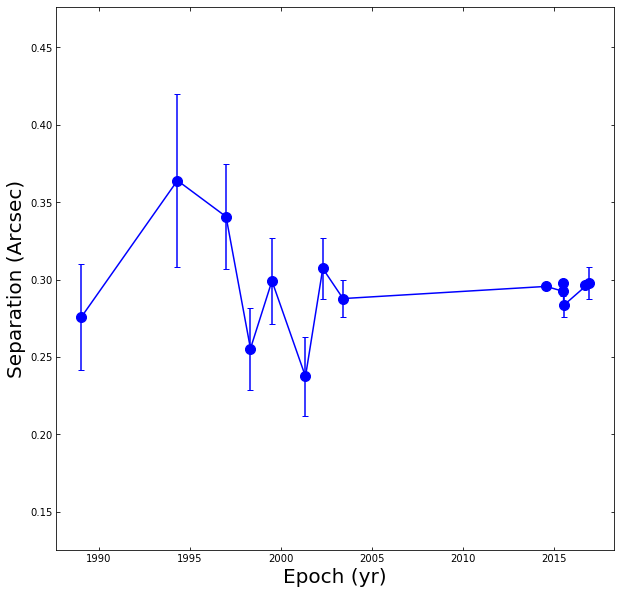

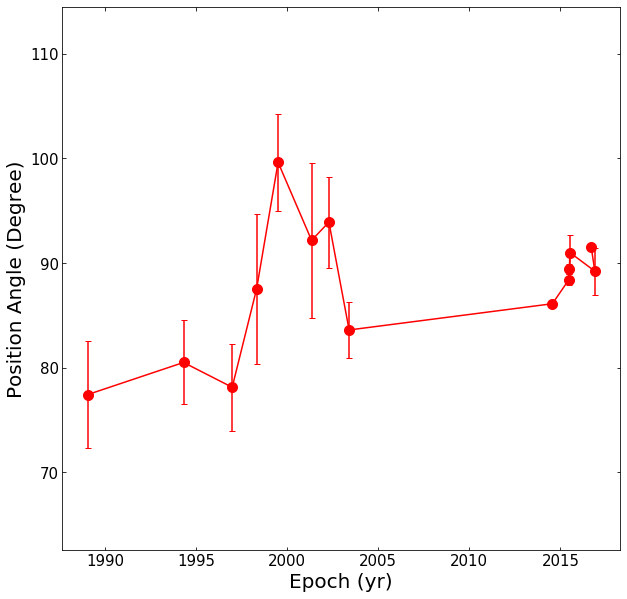

In [14]:
data_in='/home/akdiaz/Documents/Trabajo/SVS13/Images/VLA/proper_motions/'
file_A = data_in + 'pm-A-coord-err_rel.dat'
file_B = data_in + 'pm-B-coord-err_rel.dat'
plot_movements(file_A, file_B)

No handles with labels found to put in legend.


eq for RA: 0.0005987800990965202*t+2.538137709793499
eq for DEC: -0.009186172096178849*t+22.29720008517562
eq for RA: 0.0006241789738361716*t+2.5099225057460672
eq for DEC: -0.010789256173226411*t+25.52782804627961


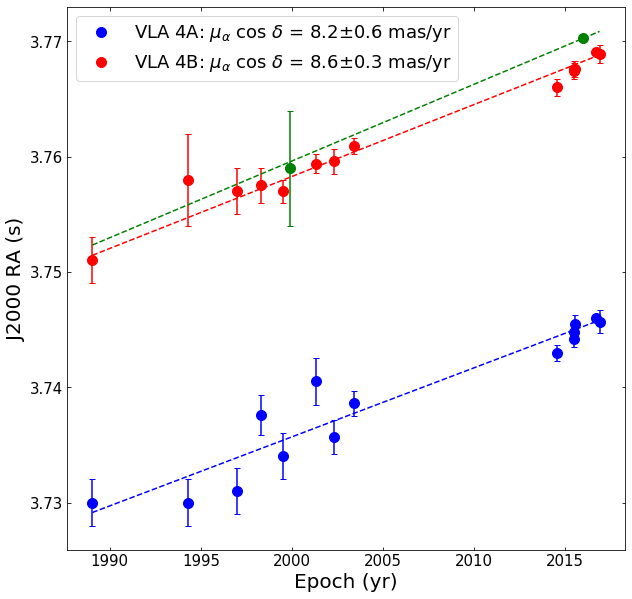

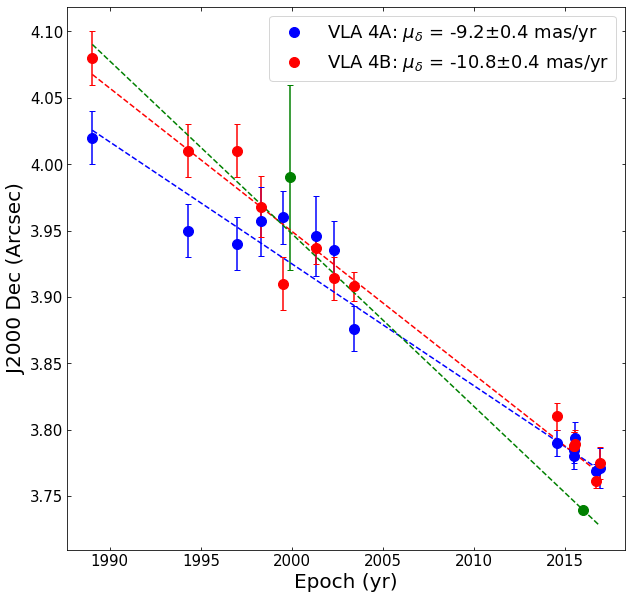

In [37]:
#gaia EDR3
data_in='/home/akdiaz/Documents/Trabajo/SVS13/Images/VLA/proper_motions/'
file_A = data_in + 'pm-A-all-final.dat'
file_B = data_in + 'pm-B-all-final.dat'
file_extra = data_in + 'pm-GAIA3&2MASS.dat'
a1 = 9.982287690504483/15/1000
b1= 3.77027 - a1*2016
a2=-13.016093571446266/1000
b2= 3.73927-a2*2016
proper_motions([file_A, file_B],'-final-gaia3',['VLA 4A', 'VLA 4B'],['b','r','g'],31,file_extra,[a1,b1,a2,b2])

No handles with labels found to put in legend.


eq for RA: 0.0005987800990965202*t+2.538137709793499
eq for DEC: -0.009186172096178849*t+22.29720008517562
eq for RA: 0.0006241789738361716*t+2.5099225057460672
eq for DEC: -0.010789256173226411*t+25.52782804627961


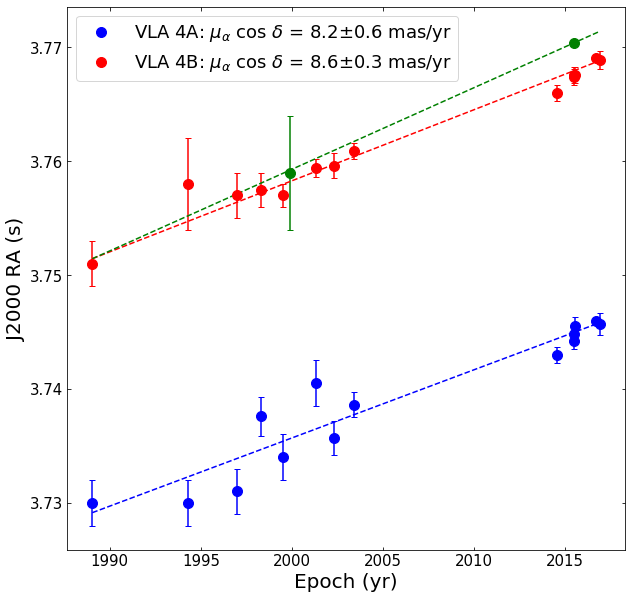

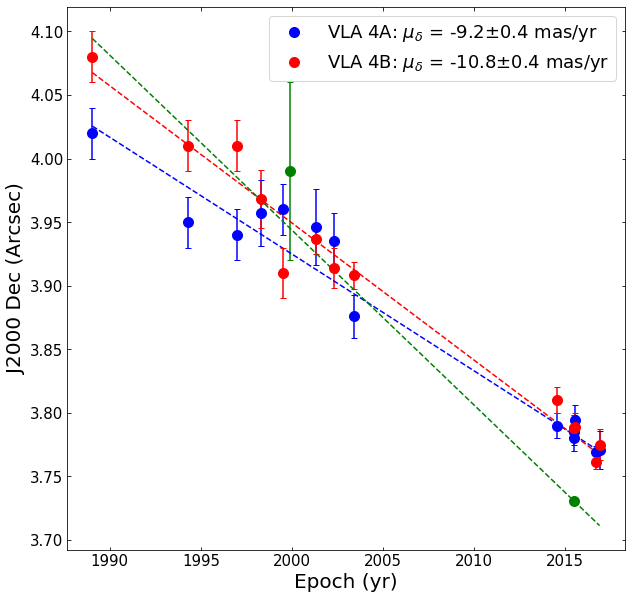

In [15]:
#gaia DR2
data_in='/home/akdiaz/Documents/Trabajo/SVS13/Images/VLA/proper_motions/'
file_A = data_in + 'pm-A-all-final.dat'
file_B = data_in + 'pm-B-all-final.dat'
file_extra = data_in + 'pm-GAIA2&2MASS.dat'
a1=10.751250164259192/15/1000
b1= 3.77040 - a1*2015.5
a2=-13.75931971408278/1000
b2= 3.7304-a2*2015.5
proper_motions([file_A, file_B],'-final',['VLA 4A', 'VLA 4B'],['b','r','g'],31,file_extra,[a1,b1,a2,b2])

In [16]:
decA1=ufloat(4.020,0.023)
decA2=ufloat(3.769,0.010)
decB1=ufloat(4.080,0.028)
decB2=ufloat(3.761,0.010)
yr1=1989.10
yr2=2016.69
((decA1-decB1)-(decA2-decB2))/(yr1-yr2)

0.0024646611090975044+/-0.0014098332974829013

In [17]:
(decA1-decB1)-(decA2-decB2)

-0.0680000000000005+/-0.03889730067755345

# Optical position

In [2]:
def coordinates_new_epoch(ar,dec,pmar,pmdec,epoch1,epoch2):
    ''' Calculates the coordinates at a especific epoch2 using the proper motions pmar, pmdec, 
    from the coordinates (ICRS) ar, dec taken at epoch1 .
    Input: ar, dec in degrees; pmar, pmdec in mas; epoch1, epoch2 in years.
    Output: new_ar, new_dec in degress'''
    f = (epoch2-epoch1)/1000/3600
    inc_ar = pmar*f
    inc_dec = pmdec*f
    new_ar = ar + inc_ar
    new_dec = dec + inc_dec
    return new_ar, new_dec

In [3]:
def separation(ar, dec, new_arc, new_dec):
    'Returns the projected separation in arcsec between to coordinates in ICRS'
    c_icrs = SkyCoord(ar, dec, frame='icrs', unit='deg')
    c_icrs_new = SkyCoord(new_ar, new_dec, frame='icrs', unit='deg')
    sep = c_icrs.separation(c_icrs_new)
    return sep.arcsec

In [4]:
#gaia DR2
ar2=52.265707466745944 #deg
dec2=31.267707198461785 #deg
#ar_err2 = 0.5026056031603101 #mas
#dec_err2 = 0.31342583907522475 #mas
pmar2 = 10.751250164259192 #mas/yr
pmdec2 = -13.75931971408278
#pmar_err = 0.7515952479133767
#pmdec_err = 0.631270289616431
gaia_epoch2 = 2015.5
#Gaia EDR3
ar3=52.26570947602043 #deg Gaia EDR3 ID:121392513273556992
dec3= 31.26770535228855 #deg
#ar_err3 = 0.20383582 #mas
#dec_err3 = 0.15332146 #mas
pmar3 = 9.982287690504483 #mas/yr
pmdec3 = -13.016093571446266
#pmar_err3 = 0.25517997
#pmdec_err3 = 0.19674583
gaia_epoch3 = 2016
#VLA_epochB_Ka = 2015.123
#VLA_epochB_Q = 2015.181
hodapp_epoch = 2012.844
VLA_epochA_X = 2016.893
VLA_epochA_K = 2015.489
VLA_epochA_Ka = 2015.516
VLA_epochA_Q = 2015.470
ALMA_hr = 2016.692
#ALMA_lr = 2016.899

In [5]:
epochs = [gaia_epoch3, gaia_epoch2, hodapp_epoch,VLA_epochA_X, VLA_epochA_K, VLA_epochA_Ka, VLA_epochA_Q,ALMA_hr]
new_ar = []
new_dec = []
for new_epoch in epochs:
    a,d = coordinates_new_epoch(ar3,dec3,pmar3,pmdec3,gaia_epoch3,new_epoch)
    new_ar.append(a)
    new_dec.append(d)

In [7]:
#separation between epochs
separation(ar3,dec3,new_ar,new_dec)

array([0.        , 0.00778171, 0.04911816, 0.01389814, 0.00795291,
       0.0075327 , 0.00824861, 0.01076989])

In [8]:
new_coord = zip(new_ar,new_dec)
radec = [au.deg2radec(ra=c[0], dec=c[1]).replace(",", " ") for c in new_coord]

03:29:03.77027, +31:16:03.73927
03:29:03.76994, +31:16:03.74578
03:29:03.76817, +31:16:03.78035
03:29:03.77087, +31:16:03.72764
03:29:03.76993, +31:16:03.74592
03:29:03.76995, +31:16:03.74557
03:29:03.76992, +31:16:03.74617
03:29:03.77073, +31:16:03.73026


In [9]:
#copy this in CASA
print('radec = ',radec)
#run this in CASA, gives error here
# radec_J2000 = [au.ICRSToJ2000(coord) for coord in radec]
# radec_J2000

radec =  ['03:29:03.77027  +31:16:03.73927', '03:29:03.76994  +31:16:03.74578', '03:29:03.76817  +31:16:03.78035', '03:29:03.77087  +31:16:03.72764', '03:29:03.76993  +31:16:03.74592', '03:29:03.76995  +31:16:03.74557', '03:29:03.76992  +31:16:03.74617', '03:29:03.77073  +31:16:03.73026']


In [10]:
#from CASA output, be extra carefull!
radec_J2000 = ['03:29:03.77088, +031:16:03.723707',
 '03:29:03.77055, +031:16:03.730217',
 '03:29:03.76878, +031:16:03.764787',
 '03:29:03.77148, +031:16:03.712077',
 '03:29:03.77054, +031:16:03.730357',
 '03:29:03.77056, +031:16:03.730007',
 '03:29:03.77053, +031:16:03.730607',
 '03:29:03.77134, +031:16:03.714697']

deg_J2000 = [au.radec2deg(c.replace(",", " ")) for c in radec_J2000]
deg_J2000

[[52.265712, 31.267701029722218],
 [52.265710625000004, 31.267702838055552],
 [52.26570325, 31.267712440833332],
 [52.2657145, 31.267697799166662],
 [52.26571058333333, 31.267702876944444],
 [52.26571066666666, 31.26770277972222],
 [52.26571054166667, 31.267702946388884],
 [52.26571391666668, 31.26769852694444]]

In [152]:
(np.array(deg_J2000[1])+np.array(deg_J2000[-2]))/2 #Kaband A & B conf

array([52.26571096, 31.26770165])

In [149]:
(np.array(deg_J2000[2])+np.array(deg_J2000[-1]))/2 #Qband A & B conf

array([52.26571098, 31.26770163])

# Toomre's Q parameter

## Us

In [5]:
M_star = 1*u.solMass
M_disk = 0.06*u.solMass
T_disk = 140*u.K #disk temperature
r_disk = 300*u.au
par.Q(M_star,M_disk,T_disk,r_disk)

<Quantity 17.42846152>

In [6]:
par.H_scale(r_disk, M_star, T_disk)

<Quantity 2.34653466e+13 m>

## Tobin (HOPS 370)

In [3]:
M_star = 2.5*u.solMass
M_disk = 0.06*u.solMass
T_disk=180*u.K #disk temperature
r_disk=50*u.au
c_sound=560*u.m*u.s**-1
par.Q(M_star,M_disk,T_disk,r_disk,c_sound=c_sound)

<Quantity 7.00694434>

# Mass from kinematics

In [2]:
def mass_from_binary_orbit(v,a):
    '''v is assumed to be in km/s and a (separation between stars) in au'''
    v_units = ((v*u.km/u.s).to(u.au/u.yr))
    M = a*v_units.value**2/np.pi**2 #in Solar Mass, from P = a**(3/2)*M**(-1/2)=np.pi*a/v
    return round(M,2)*u.solMass

def mass_from_keplerian_disk(v,r):
    '''v is assumed to be in km/s and r (disk radius) in au'''
    G = constants.G * u.m**3 * u.kg**(-1) * u.s**(-2) #Gravitational constant
    v_units = v*u.km/u.s
    r_units = (r*u.au).to(u.km)
    M = (r_units*v_units**2/G).to(u.solMass) #in Solar Mass, from v = np.sqrt(G*m/r)
    return round(M.value,2)*u.solMass

In [10]:
mass_from_keplerian_disk(4.4,45)

<Quantity 0.98 solMass>

In [11]:
4.4*np.sqrt(2)

6.222539674441619

In [30]:
v1=(1.6/1000*300*u.au/u.yr).to(u.km/u.s)
v2=(0.4/1000*300*u.au/u.yr).to(u.km/u.s)
v3=2.2*u.km/u.s

In [31]:
v=np.sqrt(v1**2+v2**2+v3**2)
v

<Quantity 3.21576746 km / s>

In [32]:
1.12/1000*v.value**2*90 #formula de Zapata

1.0423889623513025

In [37]:
m=1.12/1000*(3/cos(45*np.pi/180))**2*30 #formula de Zapata
m_min=1.12/1000*(1.5/cos(45*np.pi/180))**2*11.25 #formula de Zapata
m_max=1.12/1000*(4.5/cos(45*np.pi/180))**2*48.75 #formula de Zapata
print(m,m_min,m_max)

0.6047999999999999 0.05669999999999999 2.2113


In [28]:
mass_from_binary_orbit(v.value,90) #for the whole system

<Quantity 3.86 solMass>

In [32]:
mass_from_binary_orbit(1,90) #for the whole system

<Quantity 0.41 solMass>

In [33]:
mass_from_binary_orbit(1.25,30) #case of two stellar components in orbit for VLA 4A

<Quantity 0.21 solMass>

In [42]:
mass_from_binary_orbit(1.5,30) #case of two stellar components in orbit for VLA 4A

<Quantity 0.3 solMass>

In [12]:
mass_from_keplerian_disk(30,1) #for Sun

<Quantity 1.01 solMass>

In [24]:
mass_from_keplerian_disk(1.5/cos(45*np.pi/180),15) #case of circumstellar disk around 4A

<Quantity 0.08 solMass>

In [25]:
mass_from_keplerian_disk(0.7/cos(45*np.pi/180),5.4) #case of circumstellar disk around 4A-lower

<Quantity 0.01 solMass>

In [26]:
mass_from_keplerian_disk(2.2/cos(45*np.pi/180),23.4)

<Quantity 0.26 solMass>

In [9]:
mass_from_keplerian_disk(1.5,15) #case of two disks in A, for western

<Quantity 0.04 solMass>

In [62]:
mass_from_keplerian_disk(1,21) #case of two disks in A, for eastern

<Quantity 0.02 solMass>

In [10]:
#comprobacion keplerian disk from Murillo+2013 (https://www.aanda.org/articles/aa/pdf/2013/12/aa22537-13.pdf)
n=-0.5
v = 2*u.km/u.s 
r=47*u.au
a=v/(r**n)
((a.decompose())**2/G).to(u.solMass)

<Quantity 0.21191984 solMass>

In [11]:
mass_from_keplerian_disk(2,47) 

<Quantity 0.21 solMass>

# Mass from dust emission

In [24]:
S = [s*u.mJy for s in [43.4,63.0,10.8,4.45,3.84,2.37,3.89]] #83,109,1102 en A, B, CB (whole); 45.7,47.9,10.8 en A, B y C; 4.45,3.84 en N-in, S-in;2.37,3.89 en N-out, S-out
D = 300*u.pc
k_nu = 1.65*u.cm**2*u.g**-1 #en cm^2/g (del polvo)
f= 100 # gas-to-dust ratio
wl=0.9*u.mm
T=140*u.K #temperature of the disk
#ErT=10 #error of T
#T_d = [i*u.K for i in [T,T-ErT,T+ErT]]
#M = [par.MassMA01(S,t,D,k_nu) for t in T_d]
M = [par.MassT20(Si,T,D,k_nu,wl) for Si in S]
print(M)

[<Quantity 0.00251605 solMass>, <Quantity 0.00365233 solMass>, <Quantity 0.00062611 solMass>, <Quantity 0.00025798 solMass>, <Quantity 0.00022262 solMass>, <Quantity 0.0001374 solMass>, <Quantity 0.00022552 solMass>]


In [25]:
s_err=[3,4,110] #errores del flujo
S_err=[ufloat(s.value,err) for s,err in zip(S,s_err)]
T_err=ufloat(T.value,10)
nu=C/wl.to(u.cm)
B = 2*H*nu**3/C**2 * 1/(np.exp(H*nu/(K*T))-1)
B_err= (2*H*nu**3/C**2).value * 1/(exp((H*nu).value/(K.value*T_err))-1)
d_val=(D.to(u.cm)).value
k_nu_val=k_nu.value
B_val=B.value
factor = (1*u.solMass).to(u.kg)*1E36
M = [((D.to(u.cm))**2*Si/(k_nu*B)).decompose() for Si in S] # of dust
M_sun=[f*Mi.to(u.M_sun) for Mi in M]
M_val = [(d_val**2*Si_err/(k_nu_val*B_err)) for Si_err in S_err] # of dust
M_err = [f*M_vali/factor.value for M_vali in M_val] # of gas
print(M_sun)
print(M_err)

[<Quantity 0.00251605 solMass>, <Quantity 0.00365233 solMass>, <Quantity 0.00062611 solMass>, <Quantity 0.00025798 solMass>, <Quantity 0.00022262 solMass>, <Quantity 0.0001374 solMass>, <Quantity 0.00022552 solMass>]
[0.002516047592624914+/-0.0002577098208257801, 0.0036523271505845517+/-0.0003605317492653176, 0.0006261132258144948+/-0.006377254746574014]


## M(dust) Eq(1) Tobin+2020 (hops370)

In [23]:
#Tobin (HOPS370)
S = [s*u.Jy for s in [0.207, 0.533, 0.732e-3]]
T_d=131*u.K
D=392*u.pc
k_nu=[k*u.cm**2*u.g**(-1) for k in [0.899, 1.81, 0.13]]
wl=[l*u.mm for l in [1.3,0.87,9.1]]
[par.MassT20(Si,T_d,D,k_nui,wli) for Si, k_nui, wli in zip(S,k_nu,wl)]

[<Quantity 0.08259522 solMass>,
 <Quantity 0.04832493 solMass>,
 <Quantity 0.0954238 solMass>]

## Calculo N(H2)

In [166]:
def Plankiana(wl,T):
    nu=C/wl.to(u.cm)
    B = 2*H*nu**3/C**2 * 1/(np.exp(H*nu/(K*T))-1)
    return B

In [167]:
def column_density_H2(S,wl,T,k_nu,region,D):
    ''' '''
    f=100
    a, b =[i.value*D.value/2*u.au for i in region] #semiaxis in AU
    A_reg = np.pi*a.to(u.cm)*b.to(u.cm) #area of the region
    Ang_sol = A_reg/D.to(u.cm)**2
    B=Plankiana(wl,T)
    M_H2=-1/k_nu*f*log(1-(S.to(u.Jy)/(B*Ang_sol)).decompose())
    tau = M_H2*k_nu/f
    m_H2 = 2*1.00794*u.u #molecular mass (H_2)
    N_H2=M_H2/m_H2.to(u.g)
    return tau, N_H2

In [234]:
S = [s*u.Jy for s in [4.34157e-2,6.296531e-2]] 
region=[a*u.arcsec for a in [0.180,0.06]]

In [235]:
tau=[]
N=[]
for s in S:
    t, n = column_density_H2(s,wl,T,k_nu,region,D)
    tau.append(t)
    N.append(n)
print('en A: Tau=',np.round(tau[0],2),', N(H_2)=', N[0])
print('en B: Tau=',np.round(tau[1],2),', N(H_2)=', N[1])

en A: Tau= 0.66 , N(H_2)= 1.1956343878565518e+25 1 / cm2
en B: Tau= 1.21 , N(H_2)= 2.185811132289032e+25 1 / cm2


In [134]:
region=[a*u.arcsec for a in [0.16,0.08]]
print('en A: Tau=',np.round(tau[0],2),', N(H_2)=', N[0])
print('en B: Tau=',np.round(tau[1],2),', N(H_2)=', N[1])
print('en C: Tau=',np.round(tau[2],2),', N(H_2)=', N[2])
print('en N-In: Tau=',np.round(tau[3],2),', N(H_2)=', N[3])
print('en S-In: Tau=',np.round(tau[4],2),', N(H_2)=', N[4])
print('en N-Out: Tau=',np.round(tau[5],2),', N(H_2)=', N[5])
print('en S-Out: Tau=',np.round(tau[6],2),', N(H_2)=', N[6])

en A: Tau= 0.56 , N(H_2)= 1.0154437648002502e+25 1 / cm2
en B: Tau= 0.6 , N(H_2)= 1.0822185971815236e+25 1 / cm2
en C: Tau= 0.11 , N(H_2)= 1.9367497782633825e+24 1 / cm2
en N-In: Tau= 0.04 , N(H_2)= 7.730849474545838e+23 1 / cm2
en S-In: Tau= 0.04 , N(H_2)= 6.651388749342978e+23 1 / cm2
en N-Out: Tau= 0.02 , N(H_2)= 4.076205910242373e+23 1 / cm2
en S-Out: Tau= 0.04 , N(H_2)= 6.739627391230494e+23 1 / cm2


In [38]:
D=300
M_d=0.00062611*u.M_sun #0.0045 (high-res), 0.014 for A; 0.0059 (high-res), 0.010 for B; 0.060 for CB
d_d=np.sqrt(0.16*0.08) #diameter in arcsec # np.sqrt(0.22*0.27) (hr), np.sqrt(0.31*0.39) for A;
                                           # np.sqrt(0.20*0.32) (hr), np.sqrt(0.25*0.38) for B; 2 for CB
r_d=d_d/2*D*u.au #radio in AU 
A_d=np.pi*(r_d.to(u.cm))**2 #area of the disk
m_H2 = 2*1.00794*u.u #molecular mass (H_2)
N_H2_d=M_d/(A_d*m_H2.to(u.M_sun)) 
print(N_H2_d)

1.8367480711388617e+24 1 / cm2


In [237]:
def column_density_H2(m_d, d_d,D):
    '''m_d: disk mass in solar mass, d_d = disk diameter in arcsec, D: distance in pc'''
    r_d=d_d/2*D*u.au #radio in AU 
    M_d=m_d*u.M_sun #mass in solar mass
    A_d=np.pi*(r_d.to(u.cm))**2 #area of the disk
    m_H2 = 2*1.00794*u.u #molecular mass (H_2)
    N_H2_d=M_d/(A_d*m_H2.to(u.M_sun)) 
    return N_H2_d

In [238]:
print('for N-out (beam):', column_density_H2(0.0001374, np.sqrt(0.16*0.08), 300)) #for N-out (beam, high resolution)
print('for N-in (beam):', column_density_H2(0.00025798, np.sqrt(0.16*0.08), 300)) #for N-in (beam, high resolution)
print('for Center (beam):', column_density_H2(0.00062611, np.sqrt(0.16*0.08), 300)) #for C (beam, high resolution)
print('for S-in (beam):', column_density_H2(0.00022262, np.sqrt(0.16*0.08), 300)) #for S-in (beam, high resolution)
print('for S-out (beam):', column_density_H2(0.00022552, np.sqrt(0.16*0.08), 300),'\n') #for S-out (beam, high resolution)
print('for A (beam):', column_density_H2(0.00251605, np.sqrt(0.16*0.08), 300)) #for A (beam, high resolution)
print('for B (beam):', column_density_H2(0.00365233, np.sqrt(0.16*0.08), 300)) #for B (beam, high resolution)
print('for A (high-res):', column_density_H2(0.0048, np.sqrt(0.22*0.27), 300)) #for A (high resolution)
print('for A (normal):', column_density_H2(0.014, np.sqrt(0.31*0.39), 300),'\n') #for A (normal)
print('for B (high-res):', column_density_H2(0.0063, np.sqrt(0.20*0.32), 300)) #for B (high resolution)
print('for B (normal):', column_density_H2(0.010, np.sqrt(0.25*0.38), 300),'\n') #for B (normal)
print('for whole disk:',column_density_H2(0.064, 2, 300)) #for whole disk

for N-out (beam): 4.030748350521148e+23 1 / cm2
for N-in (beam): 7.568067390592763e+23 1 / cm2
for Center (beam): 1.8367480711388617e+24 1 / cm2
for S-in (beam): 6.530751075640597e+23 1 / cm2
for S-out (beam): 6.615825094683619e+23 1 / cm2 

for A (beam): 7.381051228041291e+24 1 / cm2
for B (beam): 1.0714427309358736e+25 1 / cm2
for A (high-res): 3.034336311391686e+24 1 / cm2
for A (normal): 4.3482114635947853e+24 1 / cm2 

for B (high-res): 3.696319448076161e+24 1 / cm2
for B (normal): 3.9526223003654853e+24 1 / cm2 

for whole disk: 6.007985896555537e+23 1 / cm2


## Calculo abundancia

In [136]:
def rel_abundance(N,NH2):
        return N/NH2

In [239]:
NH2_A = 7.38e+24 #4.3e+24 #from dust emission in A (normal)
NH2_B = 1.07e+24#4.0e+24 #from dust emission in B (normal)
NH2_C = 1.84e+24#(NH2_A+NH2_B)/2
NH2_Nin = 7.6e+23
NH2_Sin = 6.5e+23

print('for A:')
print('for CH3OCHO:',rel_abundance(4.1e17,NH2_A))
print('for CH2DOH:',rel_abundance(7.8e17,NH2_A))
print("for aGg'-(CH2OH)2:",rel_abundance(1.1e17,NH2_A),'\n')

print('for B:')
print('for CH3OCHO:',rel_abundance(2.5e17,NH2_B))
print('for CH2DOH:',rel_abundance(1.8e17,NH2_B),'\n')

print('for N-In:')
print('for 13CH3OH:',rel_abundance(1e16,NH2_Nin))
print('for CH318OH:',rel_abundance(5e15,NH2_Nin))
print('for CH3OH (min):',rel_abundance(1e16*77,NH2_Nin),'(N(CH3OH))=',1e16*77)
print('for CH3OH (max):',rel_abundance(5e15*560,NH2_Nin),'(N(CH3OH))=',5e15*560,'\n')

print('for Center:')
print('for CH3OCHO:',rel_abundance(2.3e17,NH2_C))
print('for CH2DOH:',rel_abundance(5.0e17,NH2_C))
print('for 13CH3OH:',rel_abundance(0.8e17,NH2_C))
print('for CH318OH:',rel_abundance(0.3e17,NH2_C))
print('for CH3OH (min):',rel_abundance(0.8e17*77,NH2_C),'(N(CH3OH))=',0.8e17*77)
print('for CH3OH (max):',rel_abundance(0.3e17*560,NH2_C),'(N(CH3OH))=',0.3e17*560,'\n')

print('for S-In:')
print('for 13CH3OH:',rel_abundance(3e16,NH2_Sin))
print('for CH318OH:',rel_abundance(8e15,NH2_Sin))
print('for CH3OH (min):',rel_abundance(3e16*77,NH2_Sin),'(N(CH3OH))=',3e16*77)
print('for CH3OH (max):',rel_abundance(8e15*560,NH2_Sin),'(N(CH3OH))=',8e15*560)

for A:
for CH3OCHO: 5.555555555555556e-08
for CH2DOH: 1.0569105691056911e-07
for aGg'-(CH2OH)2: 1.4905149051490515e-08 

for B:
for CH3OCHO: 2.3364485981308412e-07
for CH2DOH: 1.6822429906542057e-07 

for N-In:
for 13CH3OH: 1.3157894736842106e-08
for CH318OH: 6.578947368421053e-09
for CH3OH (min): 1.0131578947368423e-06 (N(CH3OH))= 7.7e+17
for CH3OH (max): 3.6842105263157896e-06 (N(CH3OH))= 2.8e+18 

for Center:
for CH3OCHO: 1.25e-07
for CH2DOH: 2.717391304347826e-07
for 13CH3OH: 4.347826086956522e-08
for CH318OH: 1.6304347826086957e-08
for CH3OH (min): 3.3478260869565216e-06 (N(CH3OH))= 6.16e+18
for CH3OH (max): 9.130434782608695e-06 (N(CH3OH))= 1.68e+19 

for S-In:
for 13CH3OH: 4.615384615384616e-08
for CH318OH: 1.2307692307692308e-08
for CH3OH (min): 3.553846153846154e-06 (N(CH3OH))= 2.31e+18
for CH3OH (max): 6.892307692307693e-06 (N(CH3OH))= 4.48e+18


In [ ]:
print('for CH2DOH:',rel_abundance(1.8e17,NH2_B))

# From line emission

# Methanol (CH3OH) column density and relative column densities

In [27]:
def col_density(N_d,d_ratio):
    N=N_d/d_ratio
    return N

def rel_intensity(N,Nmain):
    return N/Nmain

# using CH2DOH (deuterated methanol)
N_d=[ufloat(7.8e17,2.8e17),ufloat(1.8e17,1.2e17),ufloat(5e17,2e17)] # of CH2DOH for A, B and CB

N2=[col_density(n,0.02) for n in N_d]
N5=[col_density(n,0.05) for n in N_d]

# CH3OCHO (methyl formate) and aGg’-(CH2OH)2 (ethylene glycol)
N_m=[ufloat(4.1e17,1.6e17),ufloat(2.5e17,0.8e17),ufloat(2.3e17,0.3e17)] # of CH3OCHO for A, B and CB
N_e=[ufloat(1.1e17,0.8e17)] # of aGg’-(CH2OH)2 for A

Nrel_d2=[rel_intensity(N_di,N2i) for N_di, N2i in zip(N_d,N2)]
Nrel_m2=[rel_intensity(N_mi,N2i) for N_mi, N2i in zip(N_m,N2)]
Nrel_e2=[rel_intensity(N_ei,N2i) for N_ei, N2i in zip(N_e,N2)]

Nrel_d5=[rel_intensity(N_di,N5i) for N_di, N5i in zip(N_d,N5)]
Nrel_m5=[rel_intensity(N_mi,N5i) for N_mi, N5i in zip(N_m,N5)]
Nrel_e5=[rel_intensity(N_ei,N5i) for N_ei, N5i in zip(N_e,N5)]

print('deuterated ratio = 2%')
print('N(Methanol)',N2, 'for A, B and CB')
print('Ab(CH2DOH/methanol)', Nrel_d2,'for A, B and CB')
print('Ab(CH3OCHO/methanol)', Nrel_m2,'for A, B and CB')
print('Ab(aGg’-(CH2OH)2/methanol)', Nrel_e2,'for A\n')

print('deuterated ratio = 5%')
print('N(Methanol)',N5, 'for A, B and CB')
print('Ab(CH2DOH/methanol)', Nrel_d5,'for A, B and CB')
print('Ab(CH3OCHO/methanol)', Nrel_m5,'for A, B and CB')
print('Ab(aGg’-(CH2OH)2/methanol)', Nrel_e5,'for A\n')

deuterated ratio = 2%
N(Methanol) [3.9e+19+/-1.4e+19, 9e+18+/-6e+18, 2.5e+19+/-1e+19] for A, B and CB
Ab(CH2DOH/methanol) [0.02+/-0, 0.02+/-0, 0.02+/-0] for A, B and CB
Ab(CH3OCHO/methanol) [0.010512820512820513+/-0.005574302446250359, 0.027777777777777776+/-0.020541369813128957, 0.0092+/-0.0038707105290889414] for A, B and CB
Ab(aGg’-(CH2OH)2/methanol) [0.0028205128205128207+/-0.0022875527670345895] for A

deuterated ratio = 5%
N(Methanol) [1.56e+19+/-5.6e+18, 3.6e+18+/-2.4e+18, 1e+19+/-4e+18] for A, B and CB
Ab(CH2DOH/methanol) [0.05+/-0, 0.05+/-0, 0.05+/-2.407412430484045e-18] for A, B and CB
Ab(CH3OCHO/methanol) [0.026282051282051282+/-0.013935756115625897, 0.06944444444444445+/-0.0513534245328224, 0.023+/-0.009676776322722356] for A, B and CB
Ab(aGg’-(CH2OH)2/methanol) [0.007051282051282051+/-0.005718881917586473] for A



## M

In [39]:
d_l=0.6 #diameter in arcsec
D=300 #distance in pc
N_Sp = 3.9e14*u.cm**(-2) #column density of the species
Frac_Ab_Sp = 1/45#fractional abundance of the species (13C/12C=1/45, 15N/14N=1/234 Crocket 2014 -> Tercero 2010)
Ab_Mol = 4.1e-9 #abundance of the molecule respect to H2 (HCN=3.8e-7 hot core, 4.1e-9 compact ridge, 2.8e-7 plateu, 3.3e-8 extendend ridge, Crocket 2014)
Ab_Sp = Frac_Ab_Sp * Ab_Mol #abundance of the species with respect to H2
r_l=d_l/2*D*u.au #radio in AU 
A_l=np.pi*(r_l.to(u.cm))**2 #area of the disk
m_H2 = 2*1.00794*u.u #molecular mass (H_2)
N_H2_l = N_Sp/Ab_Sp
M_H2_l = A_l*N_H2_l*m_H2.to(u.M_sun)
M_H2=M_H2_l*(r_d/r_l)**2
print(Ab_Sp)
print(N_H2_l)
print(M_H2_l)
print(M_H2)

9.111111111111112e-11
4.2804878048780483e+24 1 / cm2
0.04103806197386875 solMass
0.0014591310924042217 solMass


# Escape velocity

In [29]:
M = 1*u.solMass
r_min=0.1#arcsec
r_max=6#arcsec
d=300 #pc
rad = [r*u.au for r in np.arange(r_min*d,r_max*d)] 
vel = [par.EscapeVel(M,r) for r in rad]

In [30]:
par.EscapeVel(M,3.5*d*u.au).value/1000

1.2999105224802598

In [35]:
x_au = [r.value for r in rad]
x_arc = np.array(x_au)/d
y = [v.value/1000 for v in vel] #en km/s

In [36]:
[i for i in zip(x_arc,y)]

[(0.1, 7.690374361883924),
 (0.10333333333333333, 7.565319290061013),
 (0.10666666666666667, 7.4461729574192335),
 (0.11, 7.332484251349767),
 (0.11333333333333333, 7.223848849425254),
 (0.11666666666666667, 7.119903159007647),
 (0.12, 7.020319189438705),
 (0.12333333333333334, 6.924800191824539),
 (0.12666666666666668, 6.833076934213858),
 (0.13, 6.744904505563475),
 (0.13333333333333333, 6.660059562004021),
 (0.13666666666666666, 6.578337944840474),
 (0.14, 6.4995526124013),
 (0.14333333333333334, 6.423531838007715),
 (0.14666666666666667, 6.350117634518218),
 (0.15, 6.279164372532468),
 (0.15333333333333332, 6.210537564735628),
 (0.15666666666666668, 6.144112793279897),
 (0.16, 6.079774760729298),
 (0.16333333333333333, 6.017416448090319),
 (0.16666666666666666, 5.956938365935386),
 (0.17, 5.898247886694407),
 (0.17333333333333334, 5.841258647918086),
 (0.17666666666666667, 5.785890017766624),
 (0.18, 5.732066615198008),
 (0.18333333333333332, 5.679717878361161),
 (0.186666666666666

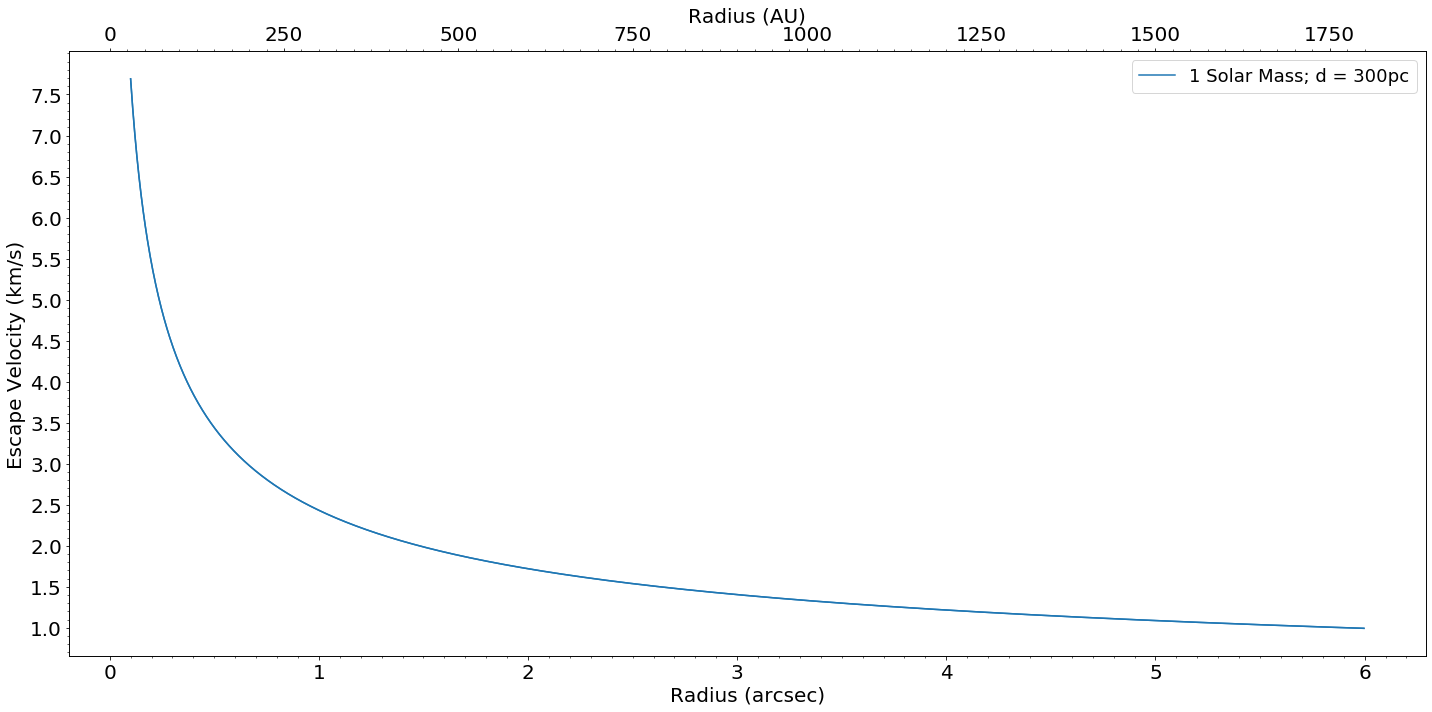

In [37]:
fig, ax1 = plt.subplots(figsize=(20, 10))
rc('ytick', labelsize=20)
rc('xtick', labelsize=20)
ax1.set_yticks(np.arange(0,max(y),0.5))
ax1.set_yticks(np.arange(0,max(y)+1,0.1),minor=True)
ax1.set_xlabel('Radius (arcsec)', fontsize=20)
ax1.set_xticks(np.arange(0,max(x_arc)+1,0.1),minor=True)
ax1.set_ylabel('Escape Velocity (km/s)', fontsize=20)
ax1.plot(x_arc, y)

ax2 = ax1.twiny()  # instantiate a second axes that shares the same y-axis

ax2.set_xlabel('Radius (AU)', fontsize=20)  # we already handled the y-label with ax1
ax2.set_xticks(np.arange(0,max(x_au)+25,25),minor=True)
ax2.plot(x_au, y, label='1 Solar Mass; d = 300pc')
plt.legend(fontsize=18)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()
plt.savefig('escape_vel.png',bbox='tight')